In [22]:
%matplotlib inline
#!pip3 install fastai;

In [23]:
from fastai.vision import *
from fastai.layers import *
from shutil import copyfile
import re
import seaborn as sns
import cv2
import warnings
import torch
warnings.filterwarnings('ignore')

In [24]:
train_csv_path = './train.csv'
train_data_path = './train_images'
test_csv_path = './test.csv'
test_data_path = './test_images'
unicode_csv_path = './unicode_translation.csv'

In [25]:
y_data = pd.read_csv(train_csv_path)
unicodes = pd.read_csv(unicode_csv_path)

In [26]:
unicodes.shape

(4781, 2)

In [27]:
int2unicode = dict(enumerate(unicodes['Unicode'].values))
unicode2int = {value:key for key,value in int2unicode.items()}

In [28]:
def create_bboxes(labels: str):
    """
    Transform label data into how fast_ai `label_from_func` likes it. That is
    an array of bounding boxes of top left, bottom right, and an array of labels for
    each box.
    [[[12,4,3,10],[14,5,4,12]], [label1], [label2]]
    """
    if('background' in labels):
        print(labels)
    dims =  [s for (i,s) in enumerate(labels.split(' ')) if i%5 != 0]
    codes = [s for (i,s) in enumerate(labels.split(' ')) if i%5 == 0]
    return [[[y1+h,x1,y1,x1+w] for [x1,y1,w,h] in np.asarray(dims,dtype=np.int64).reshape(-1,4)],codes]

In [29]:
y_data_transformed = y_data.copy(deep=True)
y_data_transformed['labels'] = y_data['labels'].map(create_bboxes)
y_data_transformed

,image_id,labels
0,100241706_00004_2,"[[[3518, 1231, 3465, 1364], [1721, 275, 1652, ..."
1,100241706_00005_1,"[[[2083, 1087, 2018, 1190], [1905, 1456, 1832,..."
2,100241706_00005_2,"[[[1433, 572, 1376, 697], [2148, 1551, 2080, 1..."
3,100241706_00006_1,"[[[3053, 1455, 3009, 1520], [1603, 1654, 1528,..."
4,100241706_00007_2,"[[[2982, 1201, 2949, 1228], [1575, 1196, 1539,..."
...,...,...
3600,umgy012-038,"[[[817, 876, 792, 899], [2381, 256, 2342, 350]..."
3601,umgy012-039,"[[[490, 426, 456, 456], [404, 584, 359, 666], ..."
3602,umgy012-040,"[[[362, 677, 327, 745], [506, 1424, 463, 1534]..."
3603,umgy012-041,"[[[836, 1582, 802, 1598], [2379, 597, 2337, 66..."


image_id                                    100241706_00004_2
labels      [[[3518, 1231, 3465, 1364], [1721, 275, 1652, ...
Name: 0, dtype: object
[3537, 927, 3445, 998]
U+306B
(92, 71, 3)


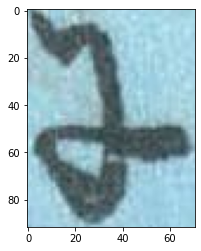

In [30]:
sample = y_data_transformed.iloc[0]
print(sample)
image_path = os.path.join(train_data_path, "%s.jpg" % sample['image_id'])
im = cv2.imread(image_path)
bbox = sample['labels'][0][5]
label = sample['labels'][1][5]
print(bbox)
print(label)

def _binarize(x):
    b = int(x.shape[0] * 2/3)
    b = b if b % 2 == 1 else b+1
    x = cv2.adaptiveThreshold(x,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,b,2)
    return x

im = im[bbox[2]:bbox[0], bbox[1]:bbox[3]]
print(im.shape)
#im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.imshow(im, aspect=1)

In [31]:
def save_cropped_image(value, index):
    
    def crop_and_save_char(bbox, char, i, im):
        char_dir = Path(f'char_images/{char}')
        char_dir.mkdir(exist_ok=True)
        new_im = im[bbox[2]:bbox[0], bbox[1]:bbox[3]]
        new_im = cv2.cvtColor(new_im, cv2.COLOR_BGR2GRAY)
        name = f'{image_id}_{i}'
        cv2.imwrite(f'char_images/{char}/{name}.jpg', new_im)
        
    
    sample = value
    image_id = sample[0]
    bboxes = sample[1][0]
    chars = sample[1][1]
    image_path = os.path.join(train_data_path, "%s.jpg" % image_id)
    im = cv2.imread(image_path)
    [crop_and_save_char(bbox, char, i, im) for (i, [bbox,char]) in enumerate(zip(bboxes,chars))]   

In [20]:
Path('char_images').mkdir(exist_ok=True)
parallel(save_cropped_image, y_data_transformed.to_numpy())

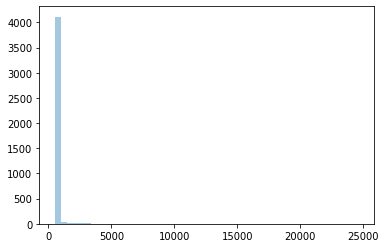

In [21]:
data = ImageList.from_folder('./char_images') \
            .split_none() \
            .label_from_folder()
_, counts = np.unique(data.train.y.items, return_counts=True)
sns.distplot(counts, bins=50, kde=False)

In [21]:
def copy_char_images(value, index):
    root, files = value
    if(len(files) < 500 and root not in ['models', './char_images']):
        work = 500-len(files)
        for i in range(0,work):
            rand = int(np.random.rand(1)[0] * len(files))
            filename = f'{files[rand][:-4]}_copy_{i}.jpg'
            copyfile(f'{root}/{files[rand]}', f'{root}/{filename}')

folders_files = []
for root, subs, files in os.walk('./char_images'):
    if root != './char_images':
        folders_files.append((root, files))

parallel(copy_char_images, folders_files)

In [32]:
def _binarize(x):
    b = int(x.shape[1] * 2/3)
    b = b if b % 2 == 1 else b+1
    x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    x = (x*255).astype('uint8')
    x = cv2.adaptiveThreshold(x,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,b,2)
    x = torch.from_numpy(x/255).float()
    x = torch.unsqueeze(x, 0)
    return x
                           

In [71]:
binarize = TfmPixel(_binarize)
db = ImageList.from_folder('./char_images') \
            .filter_by_folder(['U+306E', 'U+306B']) \
            .split_by_rand_pct() \
            .label_from_folder() \
            .transform(([binarize()], [binarize()]), size=(64,64)) \
            .databunch(bs=32)

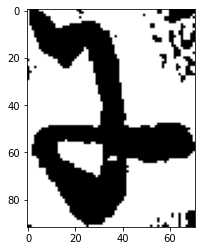

In [39]:
plt.imshow(_binarize(im)[0],cmap='gray_r')

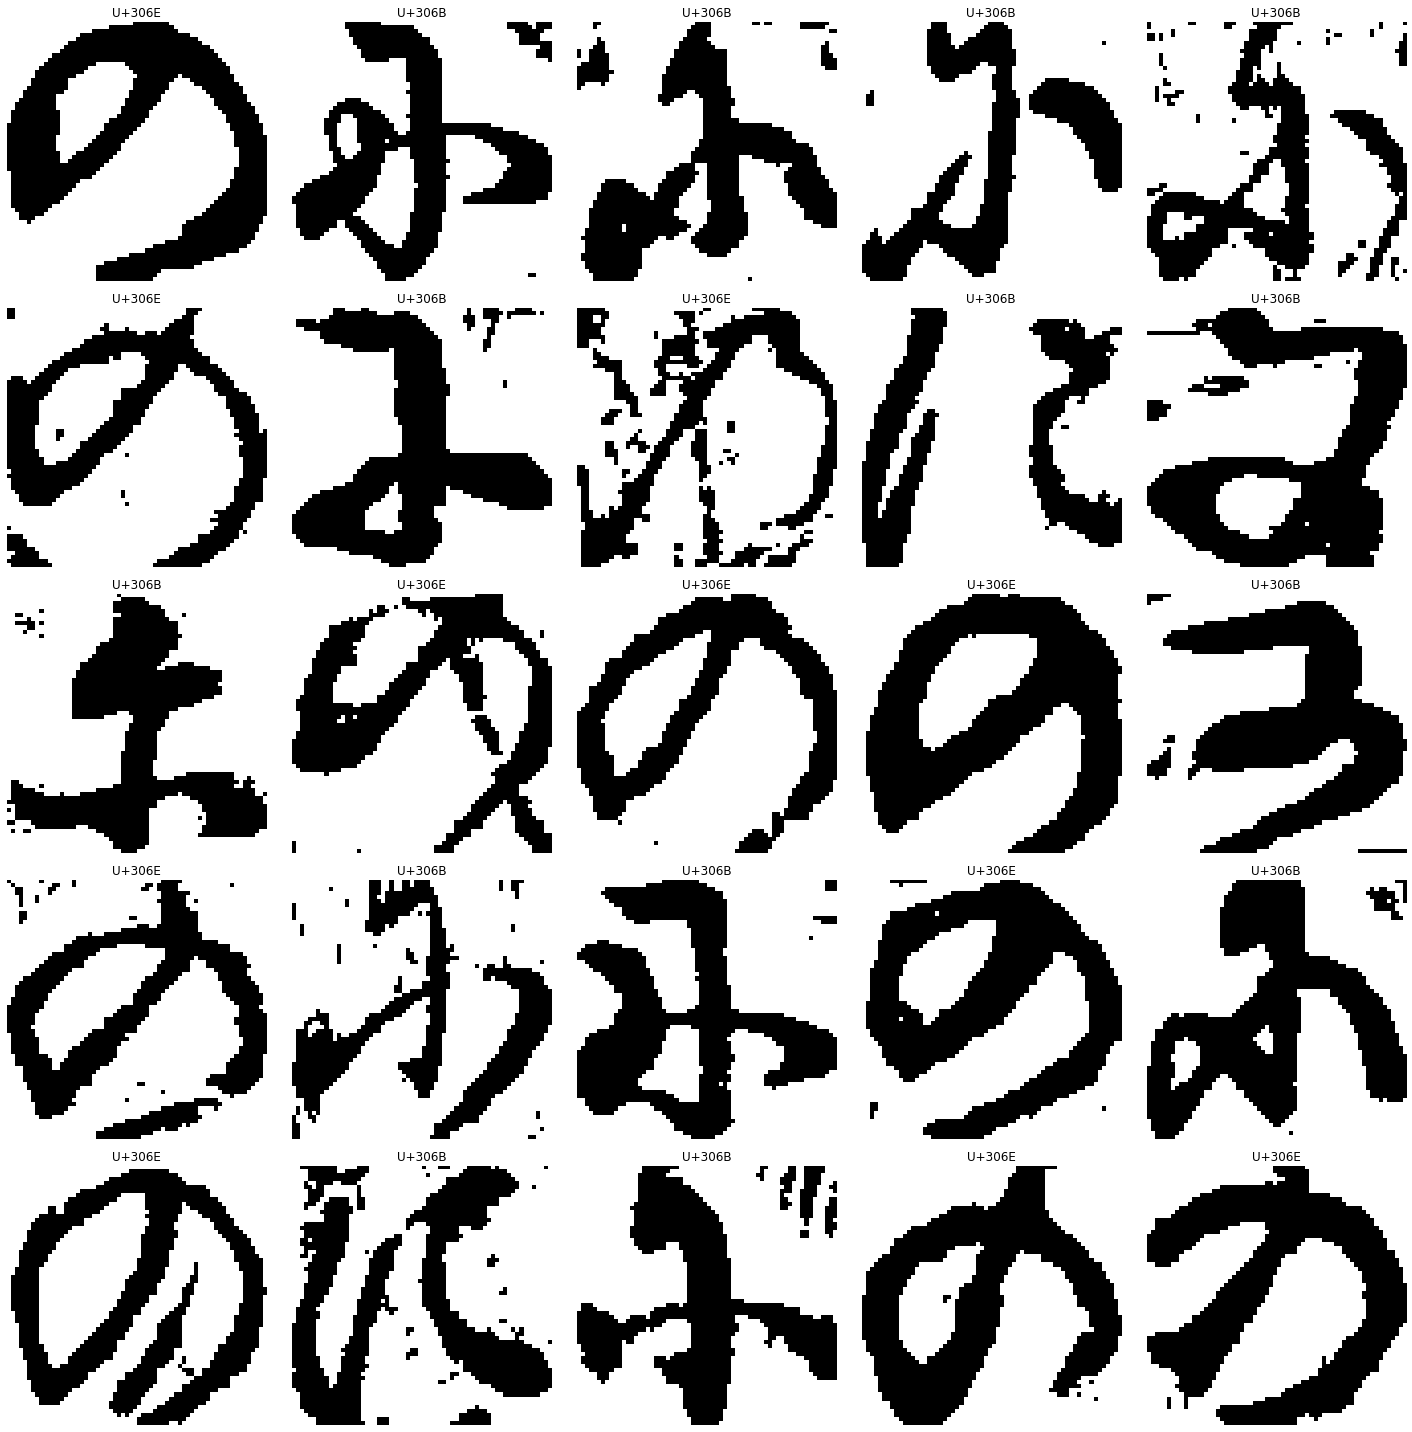

In [61]:
db.show_batch(cmap='gray')

In [62]:
db.train_ds.y.items, db.train_ds.y.classes, db.train_ds.y[0]

(array([1, 1, 1, 1, ..., 0, 0, 0, 0]), ['U+306B', 'U+306E'], Category 1)

In [63]:
db.save('./two_char_rec')

In [150]:
db = load_data('./char_images', 'two_char_rec')

In [64]:
x,y = next(iter(db.train_dl))
x

tensor([[[[1., 1., 1.,  ..., 1., 1., 0.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 0.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        ...,


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1.

In [65]:
loss = nn.CrossEntropyLoss()

class SimpleKuzuRec(nn.Module):
    
    def _conv2d_layer(self, ni, nf, stride=1):
        return nn.Sequential(
            conv2d(ni, nf, stride=stride, padding=1, bias=True),
            batchnorm_2d(nf),
            relu(True)
        )
    
    def __init__(self):
        super().__init__()
        self.conv1 = self._conv2d_layer(1, 12, stride=2)
        self.conv2 = self._conv2d_layer(12, 12)
        self.conv3 = self._conv2d_layer(12, 12)
        self.conv4 = self._conv2d_layer(12, 24, stride=2)
        self.pool1 = PoolFlatten()
        self.lin = nn.Sequential(*bn_drop_lin(24, 2, p=0.25))
        #self.lin = nn.Linear(24, 2)
        
    def forward(self, xb):
        act1 = self.conv1(xb)
        act2 = self.conv2(act1)
        act3 = self.conv3(act2)
        act4 = self.conv4(act3)
        act5 = self.pool1(act4)
        act6 = self.lin(act5)

        return act6

In [66]:
learn = Learner(db, SimpleKuzuRec(), loss_func=loss, metrics=accuracy)
print(learn.model)
print(learn.summary())

SimpleKuzuRec(
  (conv1): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool1): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten()
  )
  (lin): Sequential(
 

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


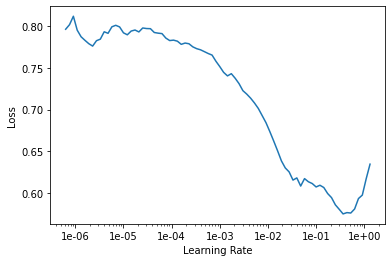

In [160]:
learn.lr_find()
learn.recorder.plot()

In [68]:
learn.fit_one_cycle(20, slice(3e-03))

epoch,train_loss,valid_loss,accuracy,time
0,0.019608,0.015358,0.995084,00:10
1,0.020897,0.023407,0.991704,00:10
2,0.029148,0.017940,0.993753,00:10
3,0.037880,0.023429,0.991499,00:10
4,0.031146,0.026255,0.991602,00:10
5,0.021375,0.027429,0.990782,00:10
6,0.031943,0.023636,0.991602,00:10


KeyboardInterrupt: 

In [139]:
sample = learn.data.train_ds[244]
print(learn.data.classes)
print(sample[1])
sample[0]

['U+6545', 'U+6587']
U+6587


In [140]:
learn.predict(sample[0])

(Category tensor(1), tensor(1), tensor([2.1599e-06, 1.0000e+00]))